### extract rel power bands from continuous data
created: 20200723  
Purpose: mostly testing kremen 2018 script

In [1]:
%matplotlib inline

# general use
import numpy as np
import h5py
from tqdm import tqdm
import scipy as sp

# plotting
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
flatui = ["#417CA7", "#D93A46", "#2ecc71", "#ff9408", "#6a79f7", "#f075e6"]
sns.set_palette(sns.color_palette(flatui))

# custom functions here
import sys
sys.path.append("./../scripts/")
import filtering_tools as filt


In [2]:
# import data

filename = "a0f66459_d6_continuous_labeled.h5"
fin = h5py.File(filename, "r")
print(list(fin.keys()))

# the t variable isn't right...i messed up somewhere

chan = fin.get('chan')
data_labels = fin.get('data_labels')
data_neuro = fin.get('data_neuro')
data_eog = fin.get('data_eog')
fs = 500
t = np.linspace(0,len(data_neuro)/500,len(data_neuro))

print('data_neuro: ', data_neuro.shape)
print('data_eog: ', data_eog.shape)
print('hours of data: %.2f' % (len(data_neuro)/fs/60/60))

['chan', 'data_eog', 'data_labels', 'data_neuro', 't']
data_neuro:  (20519500, 63)
data_eog:  (20519500,)
hours of data: 11.40


Text(0.5, 1.0, 'wake = 1, sleep = 0')

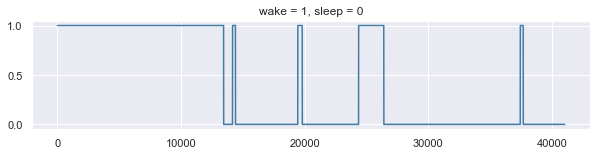

In [3]:
plt.figure(figsize=[10,2])
plt.plot(t,data_labels)
plt.title('wake = 1, sleep = 0')

In [8]:
# cut to 30-second segments

n_epochs = int(np.floor(len(data_neuro)/fs/30))

# cut neuro
data_neuro_cut = data_neuro[:n_epochs*30*fs,:].T # round to nearest 30-s
data_neuro_ep = np.reshape(data_neuro_cut,(63, -1, 30*fs))

# add normalized eog signal [0,1]
data_eog_norm = (data_eog - np.min(data_eog)) / (np.max(data_eog) - np.min(data_eog))

data_eog_cut = data_eog[:n_epochs*30*fs] # round to nearest 30-s
data_eog_ep = np.reshape(data_eog_cut,(-1, 30*fs))

data_eog_cut = data_eog_norm[:n_epochs*30*fs] # round to nearest 30-s
data_eog_norm_ep = np.reshape(data_eog_cut,(-1, 30*fs))

# cut labels
data_labels_ep = np.zeros(n_epochs)
data_labels_temp = np.reshape(data_labels[:n_epochs*30*fs],(-1,fs*30))
for i in range(n_epochs):
    data_labels_ep[i] = data_labels_temp[i,:].mean().round()
    
print(data_neuro_ep.shape)
print(data_eog_ep.shape)
print(data_labels_ep.shape)

(63, 1367, 15000)
(1367, 15000)
(1367,)


#### filter exactly in kremen 2018
relative spectral power bands (n=8) with 6th order butterworth, zero-phase 
**power bands:**
- 0.1 - 4
- 4 - 8
- 8 - 13
- 13 - 30
- 30 - 55
- 65 - 115
- 125 - 175
- 185 - 235


abs power in band:  165.9472851997753


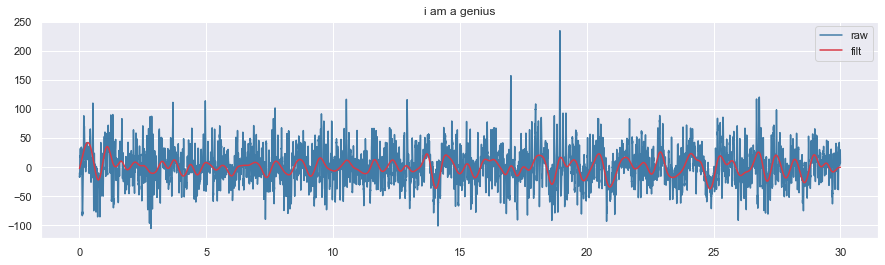

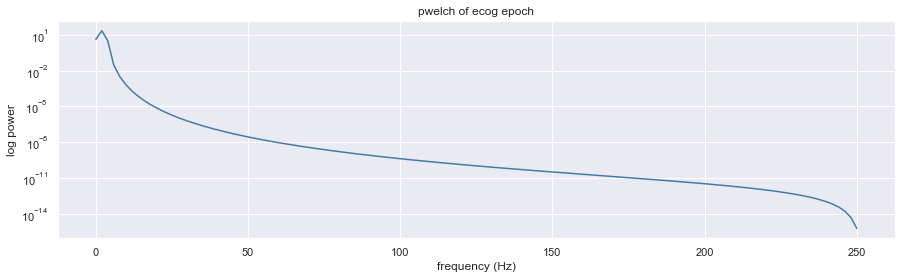

In [11]:
# flex filter example

sig = data_neuro_ep[0,0,:]
sig_filt = filt.flex_filter(sig, fs, f_cut=0.1, f_cut2=2, btype='bandpass', order=6)

plt.figure(figsize=[15,4])
plt.plot(np.linspace(0,30,30*fs),sig,label='raw')
plt.plot(np.linspace(0,30,30*fs),sig_filt,label='filt')
plt.legend()
plt.title('i am a genius');

# power = mean of sqaured power
print('abs power in band: ', str(np.square(sig_filt).mean()))

# psd of ecog
[f, px] = sp.signal.welch(sig_filt,fs)

plt.figure(figsize=[15,4])
plt.semilogy(f,px)
plt.xlabel('frequency (Hz)')
plt.ylabel('log power')
plt.title('pwelch of ecog epoch');

abs power in band:  6321.597264303213


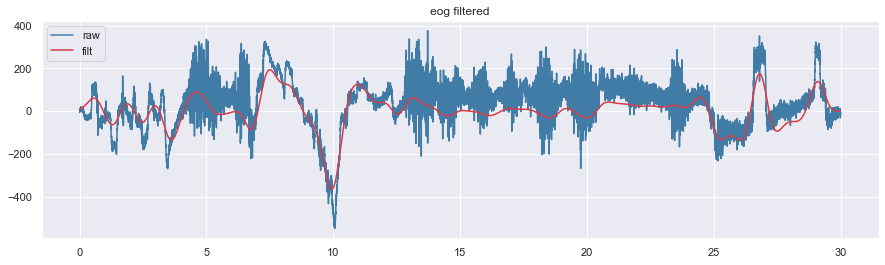

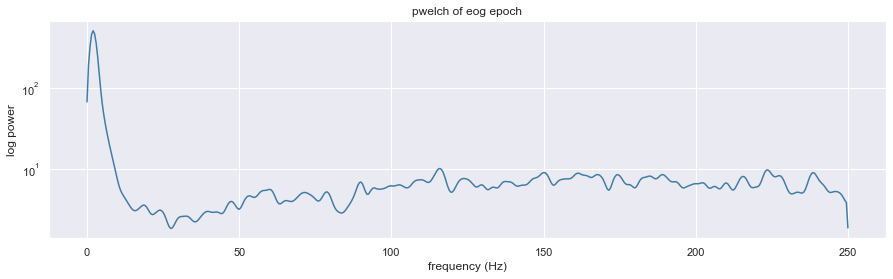

In [12]:
# look at eog
# bp 0.1-1 Hz seems to produce a nice filter

sig = data_eog_ep[0,:]
sig_filt = filt.flex_filter(sig, fs, f_cut=0.1, f_cut2=1, btype='bandpass', order=6)

plt.figure(figsize=[15,4])
plt.plot(np.linspace(0,30,30*fs),sig,label='raw')
plt.plot(np.linspace(0,30,30*fs),sig_filt,label='filt')
plt.legend()
plt.title('eog filtered');

# power = mean of sqaured power
print('abs power in band: ', str(np.square(sig_filt).mean()))

# psd of eog
[f, px] = sp.signal.welch(sig,fs,nfft=1000)

plt.figure(figsize=[15,4])
plt.semilogy(f,px)
plt.xlabel('frequency (Hz)')
plt.ylabel('log power')
plt.title('pwelch of eog epoch');

## Extracting EOG features
We have horizontal EOG (HEOG) data. 
- Delta spectral power 0.5-4 Hz (Betta 2016)
- Slow eye movements 0.1-0.3 Hz (estrada 2006)
- Rapid eye movements 0.3 - 0.45 Hz (Estrada 2006)
- Time entropy / epoch (Zoubek 2007)

In [13]:
# extracing EOG features

data_eog_delta = np.zeros(n_epochs)
data_eog_entropy = np.zeros(n_epochs)
data_eog_75p = np.zeros(n_epochs)

for ep in tqdm(range(n_epochs)):
    sig = data_eog_ep[ep,:]
    sig_norm = data_eog_norm_ep[ep,:]
    
    # delta band
    low = 0.1
    high = 2

    data_eog_delta[ep] = np.square(filt.flex_filter(sig, fs, f_cut=low, f_cut2=high, btype='bandpass', order=6)).mean()
    
    # entropy
    data_eog_entropy[ep] = sp.stats.entropy(sig_norm)
    
    # 75th percentile - normalized
    data_eog_75p[ep] = sp.stats.scoreatpercentile(sig_norm,75)
            


100%|██████████| 1367/1367 [00:02<00:00, 664.47it/s]


In [14]:
# filter all epochs

pwbs = [[0.1,4],[4,8],[8,13],[13,30],[30,55],[65,115],[125,175],[185,235]]

data_neuro_pwb_abs = np.zeros((63,n_epochs,8))

for ep in tqdm(range(n_epochs)):
    for ch in range(63):
        sig = data_neuro_ep[ch,ep,:]
        
        for i in range(len(pwbs)):
            low = pwbs[i][0]
            high = pwbs[i][1]
            
            data_neuro_pwb_abs[ch,ep,i] = np.square(filt.flex_filter(sig, fs, f_cut=low, f_cut2=high, btype='bandpass', order=6)).mean()
            
        
# np.save('data_neuro_pwb_abs.npy',data_neuro_pwb_abs)


100%|██████████| 1367/1367 [08:40<00:00,  2.63it/s]


NameError: name 'data_neuro_pwbs_abs' is not defined

In [14]:
data_neuro_pwb_abs = np.load('data_neuro_pwb_abs.npy')

In [15]:
# relative

data_neuro_pwb_rel = np.zeros(data_neuro_pwb_abs.shape)
sum_pwb = data_neuro_pwb_abs.sum(2)

for i in range(8):
    data_neuro_pwb_rel[:,:,i] = data_neuro_pwb_abs[:,:,i] / sum_pwb

Text(0, 0.5, 'EOG 75th percentile, normalized')

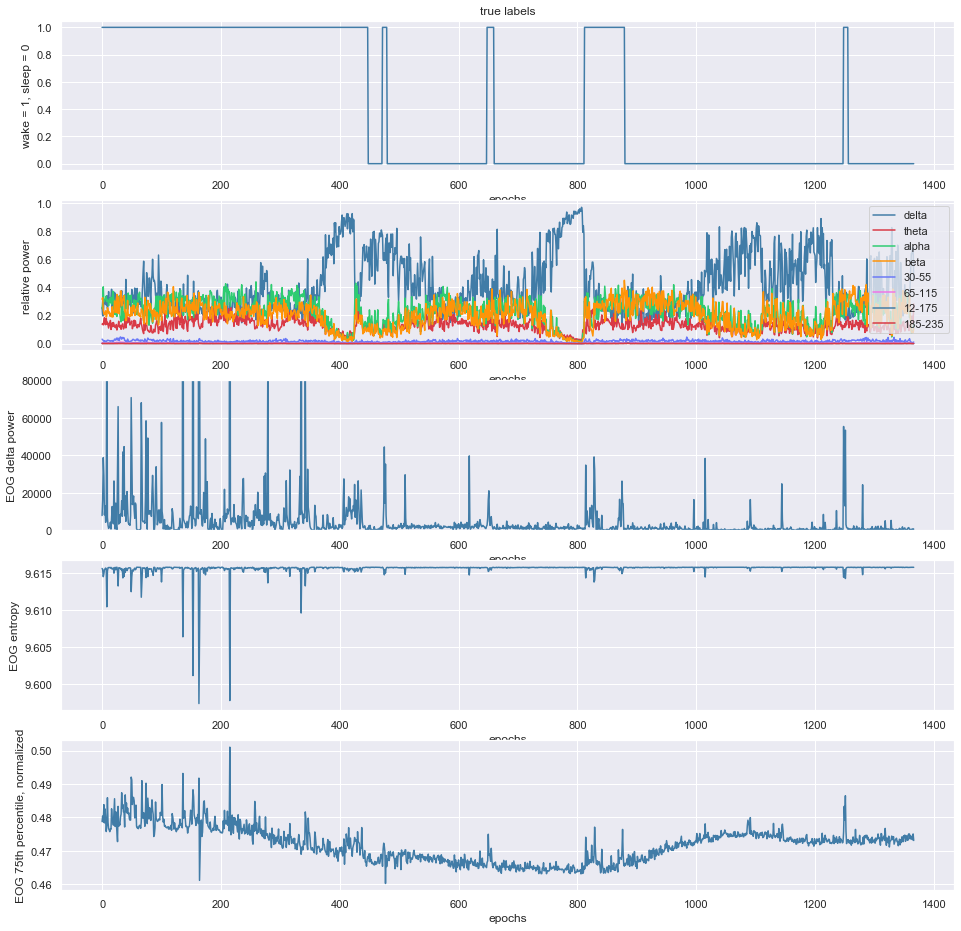

In [21]:
plt.figure(figsize=[16,16])
plt.subplot(5,1,1)
plt.plot(data_labels_ep)
plt.xlabel('epochs')
plt.ylabel('wake = 1, sleep = 0')
plt.title('true labels')

# plt.subplot(4,1,2)
# plt.plot(data_neuro_pwb_abs[0,:,:])
# plt.xlabel('epochs')
# plt.ylabel('absolute power')

plt.subplot(5,1,2)
plt.plot(data_neuro_pwb_rel[0,:,:])
plt.xlabel('epochs')
plt.ylabel('relative power')
plt.legend(['delta','theta','alpha','beta','30-55','65-115','12-175','185-235'])

plt.subplot(5,1,3)
plt.plot(data_eog_delta)
plt.ylim([0,80000])
plt.xlabel('epochs')
plt.ylabel('EOG delta power')

plt.subplot(5,1,4)
plt.plot(data_eog_entropy)
plt.xlabel('epochs')
plt.ylabel('EOG entropy')

plt.subplot(5,1,5)
plt.plot(data_eog_75p)
plt.xlabel('epochs')
plt.ylabel('EOG 75th percentile, normalized')


In [33]:
import scipy.io as sio

sio.savemat('a0f_30s_pwb_rel.mat', {'data':data_neuro_pwb_rel})